In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from sklearn.preprocessing import StandardScaler
#from sklearn.metrics import average_precision_score, precision_recall_curve, f1_score
#from sklearn.metrics import roc_auc_score
#from sklearn.metrics import roc_curve, auc 
#from sklearn.model_selection import train_test_split
#from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
#from pathlib import Path
import os
#import sys
import pickle
#import seaborn as sns
from utils.model import load_bird_list, load_birdnet_weights, import_dataset
import yaml
from matplotlib.ticker import ScalarFormatter


with open('config.yaml', 'r') as file: # load yaml config
    CONFIG = yaml.safe_load(file)


In [2]:
bird_list_index, num_class = load_bird_list() 
x_train, y_train, x_val, y_val, x_test, y_test, _ , _,  _, _ = import_dataset(bird_list_index) # load train, val and test set


In [3]:

# load train labels and sampling data
with open("/home/corentin/Documents/datasets/results_data/results_samples_revcor_L2.pkl" , "rb") as file:
    loaded_data1 = pickle.load(file)
samples_vect, mAP_list, cmAP_list, class_AP_list = loaded_data1



In [4]:
print(np.mean(mAP_list))
print(np.mean(cmAP_list))


0.5841279166904906
0.3976644959205143


In [ ]:
# computation of the influence score for each sample
# = correlation with the vector of presence/abscence at each iteration and the cmAP/AP

samples_num = np.shape(samples_vect)[1]
mAP_correlations = []
cmAP_correlations = []

for i in range(samples_num):

    r = np.corrcoef(samples_vect[:,i], mAP_list)
    mAP_correlations.append(r[0,1])

    r = np.corrcoef(samples_vect[:,i], cmAP_list)
    cmAP_correlations.append(r[0,1])

mAP_influence_score = np.array(mAP_correlations)
cmAP_influence_score = np.array(cmAP_correlations)


In [8]:
# compute mean cmAP influence score by species

influence_matrix = y_train.T  * cmAP_influence_score
class_mean_influence = []
for i in range(np.shape(influence_matrix)[0]):
    influence_vector = influence_matrix[i,:]
    non_nul_id = influence_vector != 0
    class_mean_influence.append(np.mean(influence_vector[non_nul_id]))
class_mean_influence = np.array(class_mean_influence)

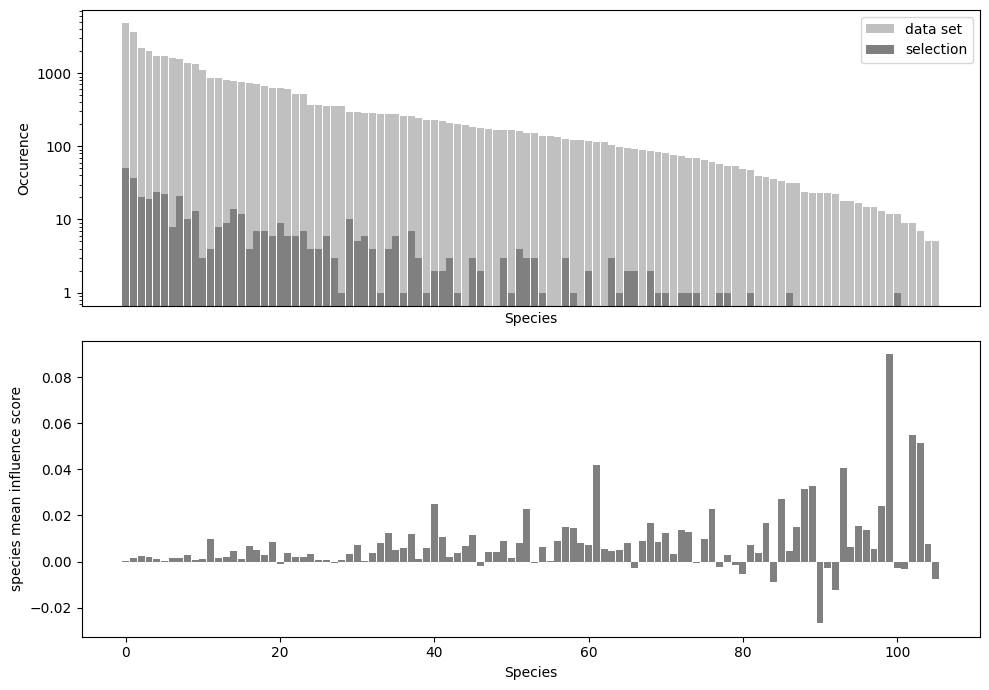

In [ ]:
species_count_dataset = np.sum(y_train,axis=0) + np.sum(y_val,axis=0) + np.sum(y_test,axis=0)

# random selection of 500 samples to plot species distribution
idx_train_samples = np.arange(0,np.shape(y_train)[0])
idx_train_selection = np.random.choice(idx_train_samples, size=500, replace=False)
y_select = y_train[idx_train_selection,:]
select_count = np.sum(y_select, axis=0)


fig, ax = plt.subplots(2,1, figsize=(10, 7))
sorted_indices = np.argsort(species_count_dataset)[::-1]

ax[0].bar(range(len(sorted_indices)), species_count_dataset[sorted_indices], color="silver", width=0.9, label= "data set")
ax[0].bar(range(len(sorted_indices)), select_count[sorted_indices], color="gray", width=0.9, label="selection")

ax[0].set_xticks([])
ax[0].set_yscale('log')
formatter = ScalarFormatter()
formatter.set_scientific(False)
ax[0].yaxis.set_major_formatter(formatter)
ax[0].set_ylabel("Occurence")
ax[0].set_xlabel("Species")
ax[0].legend()

ax[1].bar(range(len(sorted_indices)), class_mean_influence[sorted_indices] , color="gray", width=0.9, label="selection")
ax[1].set_ylabel("species mean influence score")
ax[1].set_xlabel("Species")

# Show plot
plt.tight_layout()

fig.savefig("species_distribution2.pdf", bbox_inches='tight')